In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS, Predictive
from src.data.data_loader import load_uplift
from src.data.preprocessing import load_thickness_time_series
from src.models.paths import PROJECT_ROOT
from src.models.pyro_custom import IntervalFoldedDistribution
from src.models.solid_earth_utils import compute_love_numbers, greens_function

print(PROJECT_ROOT)
pyro.set_rng_seed(42)

/mnt/c/Users/dnjllg/OneDrive - Danmarks Tekniske Universitet/Dokumenter/PhD/Courses/Model-based Machine Learning/premis


In [2]:
class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()

        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h1_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.h2_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)

        # Activation functions
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        # Forward pass
        X = self.relu(self.in_layer(X))
        X = self.relu(self.h1_layer(X))
        X = self.relu(self.h2_layer(X))
        X = self.out_layer(X)

        return X

In [3]:
2**11

2048

In [4]:
Nr = np.arange(1, 7).tolist()
radius = [6371e3, 6341e3, 6311e3, 5951e3, 5701e3, 3480e3]
density = [3.037e3, 3.230e3, 3.438e3, 3.871e3, 4.978e3, 10.750e3]
rigidity = [0.50605e11, 0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11, 0.0000e11]
bulk = [5.7437e10, 5.7437e10, 9.9633e10, 1.5352e11, 3.2210e11, 1.1018e12]
viscosity = [1.0e55, 1.0e21, 1.0e21, 1.0e21, 2.0e21, 0.0e21]

df_em = pd.DataFrame(
    np.array([Nr, radius, density, rigidity, bulk, viscosity]).T,
    columns=["Nr", "radius", "density", "rigidity", "bulk", "viscosity"],
)

lmax = 2**11
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

df = load_uplift()
height = df.Thickness.values
uplift = df.Up_kuaq.values

df_em

/home/dnjllg/miniconda3/envs/MBML/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3230.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [9]:
llmax = [2**i for i in np.arange(7, 14)]
llmax

[128, 256, 512, 1024, 2048, 4096, 8192]

In [11]:
gf_1 = []
gf_2 = []
append_1 = gf_1.append
append_2 = gf_2.append
llmax = [2**i for i in np.arange(7, 14)]
# [128, 256, 512, 1024, 2048, 4096, 8192]
for lmax in llmax:
    print(lmax)
    # lmax = 2**11
    lmin = 0
    lstep = 1
    CONF = {
        "EARTH_FILE": "earth_M3L70V01c.txt",
        "COMPRESS": "1",
        "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
        "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
    }
    hlove, nlove = compute_love_numbers(df_em=df_em, CONF=CONF, verbose=0)

    append_1(
        greens_function(
            hlove,
            nlove,
            [68.704665, -33.214577],
            [68.58700000, -33.05270000],
            arsurf=80e3 * 80e3,
        )
    )
    append_2(
        greens_function(
            hlove,
            nlove,
            [68.704665, -33.214577],
            [68.14029705, -31.45179999],
            arsurf=80e3 * 80e3,
        )
    )

128
256
512
1024
2048
4096
8192


In [26]:
np.array(gf_1)/np.array(gf_2)

array([ 1.41816331, -0.05404674,  0.86720399,  0.88714451,  0.90823794,
        0.89302833,  0.89198702])

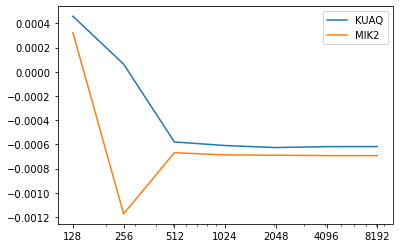

In [24]:
plt.semilogx(llmax, gf_1, label="KUAQ")
plt.semilogx(llmax, gf_2, label="MIK2")
plt.xticks(ticks=llmax, labels = llmax)
plt.legend()
plt.show()

In [ ]:
hlove, nlove = compute_love_numbers(df_em=df_em, CONF=CONF, verbose=0)
gf_kuaq = greens_function(
    hlove,
    nlove,
    [68.704665, -33.214577],
    [68.58700000, -33.05270000],
    arsurf=80e3 * 80e3,
)
gf_mik2 = greens_function(
    hlove,
    nlove,
    [68.704665, -33.214577],
    [68.14029705, -31.45179999],
    arsurf=80e3 * 80e3,
)
gf = pyro.deterministic("gf", torch.tensor([gf_kuaq, gf_mik2]))
gf

In [4]:
t = np.arange(len(uplift))
G = np.vstack([t**3, t**2, t, np.ones_like(t)]).T
a, b, c, d = np.linalg.lstsq(G, uplift, rcond=None)[0]
trend = a * t**3 + b * t**2 + c * t + d
a, b, c, d

(0.00013715258698306744,
 -0.03206968059261704,
 3.5151983255279635,
 -132.5784591357166)

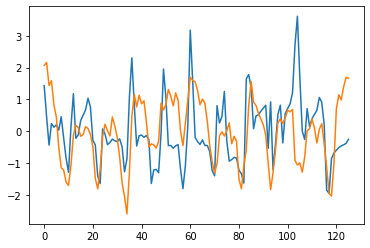

In [5]:
gf_test = -2e-4
tmp = (height - np.mean(height)) / np.std(height)
tmp2 = uplift - trend
tmp2 = (tmp2 - np.mean(tmp2)) / np.std(tmp2)
plt.plot(5e3 * tmp * gf_test)
plt.plot(tmp2)

In [6]:
# For modelling seasonality at some point

# X_time = np.concatenate([pd.get_dummies(df[x]) for x in ["dow", "tod"]], axis=1)
# pd.get_dummies(df["Time"])
# Make month columns
df1 = pd.concat([df, df.Time.dt.month], axis=1)
df1.columns = [*df1.columns[:-1], "Month"]
df1.head()

# make one hot encoding of month number
month_number = np.array(pd.get_dummies(df1["Month"]))

In [7]:
standardized_height = height - np.mean(height) / np.std(height)
X_cat = np.concatenate([standardized_height[np.newaxis].T, month_number], axis=1)
X_train = torch.tensor(X_cat).float()
y_train = torch.tensor(uplift - trend).float()
y_train = (y_train - y_train.mean()) / y_train.std()
len(X_train)

126

In [8]:
X_train

tensor([[-991.6353,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [-372.6030,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [ 188.7872,    0.0000,    0.0000,  ...,    1.0000,    0.0000,
            0.0000],
        ...,
        [ 182.0744,    0.0000,    0.0000,  ...,    0.0000,    1.0000,
            0.0000],
        [ 153.4605,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            1.0000],
        [  71.9750,    1.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000]])

In [11]:
hlove, nlove = compute_love_numbers(df_em=df_em, CONF=CONF, verbose=0)
gf_kuaq = greens_function(
    hlove,
    nlove,
    [68.704665, -33.214577],
    [68.58700000, -33.05270000],
    arsurf=80e3 * 80e3,
)
gf_mik2 = greens_function(
    hlove,
    nlove,
    [68.704665, -33.214577],
    [68.14029705, -31.45179999],
    arsurf=80e3 * 80e3,
)
gf = pyro.deterministic("gf", torch.tensor([gf_kuaq, gf_mik2]))
gf

tensor([ 6.3530e-05, -1.1755e-03])

In [15]:
hlove, nlove = compute_love_numbers(df_em=df_em, CONF=CONF, verbose=0)
gf_kuaq = greens_function(
    hlove,
    nlove,
    [68.704665, -33.214577],
    [68.58700000, -33.05270000],
    arsurf=80e3 * 80e3,
)
gf_mik2 = greens_function(
    hlove,
    nlove,
    [68.704665, -33.214577],
    [68.14029705, -31.45179999],
    arsurf=80e3 * 80e3,
)
gf = pyro.deterministic("gf", torch.tensor([gf_kuaq, gf_mik2]))
gf

tensor([-0.0006, -0.0007])

In [17]:
hlove.shape

(2049,)

In [10]:
# MIK2    68.14029705   -31.45179999
# KUAQ    68.58700000   -33.05270000
def model(X, obs=None, df_em=None):
    N = len(X)
    t = torch.linspace(0, 1, N)

    sigma_w = pyro.sample("sigma", dist.HalfCauchy(1.2 * torch.ones(N)))

    # rigidity layer 1
    loc, scale = 2, 0.5
    rigidity_dist_1 = IntervalFoldedDistribution(
        dist.Normal(loc, scale), lower=loc * 1e-2, upper=loc * 5e1
    )
    rigidity_1 = 1e11 + 1e10 * pyro.sample("rigidity_1", rigidity_dist_1)

    # rigidity layer 2
    loc, scale = 4, 0.5
    rigidity_dist_2 = IntervalFoldedDistribution(
        dist.Normal(loc, scale), lower=loc * 1e-2, upper=loc * 5e1
    )
    rigidity_2 = 1e11 + 1e10 * pyro.sample("rigidity_2", rigidity_dist_2)

    # dictionary = {"sample": sample1}
    df_em["rigidity"][0] = rigidity_1.item()
    df_em["rigidity"][1] = rigidity_2.item()

    # Draw Love Numbers
    hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)

    # Draw Greens Function
    gf = pyro.deterministic(
        "gf",
        torch.tensor(
            greens_function(
                hlove,
                nlove,
                [68.704665, -33.214577],
                [68.58700000, -33.05270000],
                arsurf=80e3 * 80e3,
            )
        ),
    )

    # Draw target
    with pyro.plate("data"):
        w = pyro.sample(
            "w", dist.Normal(-gf * X[:, 0], sigma_w), obs=obs
        )  # 1e5 is a scaling constant

    return w

In [11]:
# import os
# os.environ["OMP_NUM_THREADS"] = '1'
# Run inference in Pyro

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=20, warmup_steps=10, num_chains=1)
mcmc.run(X_train, y_train, df_em)

Sample: 100%|████| 30/30 [16:41, 33.38s/it, step size=8.27e-02, acc. prob=0.824]


In [12]:
# Show summary of inference results
mcmc.summary()  # exclude_deterministic=False


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  rigidity_1      1.99      0.52      2.02      1.25      2.81     31.81      0.96
  rigidity_2      3.83      0.46      3.87      3.15      4.59     12.61      0.95
    sigma[0]      2.18      1.34      1.71      1.03      4.41     66.08      0.96
    sigma[1]      2.79      1.85      2.25      0.94      5.71     16.52      1.00
    sigma[2]      2.20      1.34      1.65      0.88      4.41     15.50      0.95
    sigma[3]      1.78      0.77      1.52      0.92      3.35     18.92      0.95
    sigma[4]      1.29      1.10      0.84      0.36      3.16     51.80      0.95
    sigma[5]      1.09      0.63      0.94      0.27      2.16     38.80      1.00
    sigma[6]      1.01      0.59      0.86      0.30      1.87     16.51      0.96
    sigma[7]      2.16      1.94      1.30      0.49      5.51     32.45      0.96
    sigma[8]      1.51      0.65      1.21      0.61      2.33     25.21      1.07
   

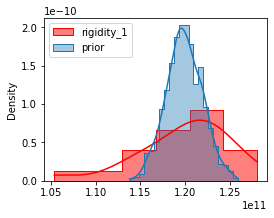

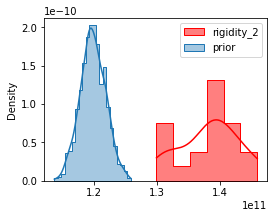

In [13]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1", "rigidity_2"]

rigidity_dist_prior = dist.Normal(2 * torch.ones(1000), 0.2)
rigidity_prior = 1e11 + 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)

for node in nodes:
    plt.figure(figsize=(4, 3))
    sns.histplot(
        1e11 + 1e10 * samples[node],
        label=node,
        kde=True,
        stat="density",
        element="step",
        color="red",
    )
    sns.histplot(
        rigidity_prior,
        label="prior",
        kde=True,
        stat="density",
        element="step",
        alpha=0.4,
    )
    plt.legend()
    plt.show()

#### Get deterministic part out

In [14]:
from pyro.infer import Predictive

predictive = Predictive(model, samples)(X_train, None, df_em)
for k, v in predictive.items():
    print(f"{k}: {tuple(v.shape)}")

gf: (20, 1)
w: (20, 126)


In [15]:
gf_res, w_res = predictive.items()
gf_res, w_res = gf_res[1], w_res[1]

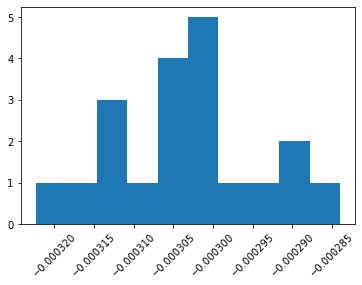

In [16]:
plt.hist(gf_res.numpy())
plt.xticks(rotation=45);

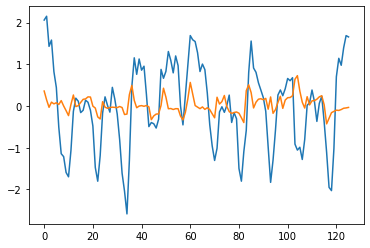

In [51]:
w_pred = (gf_res * X_train[:, 0]).mean(axis=0)
plt.plot(y_train)
plt.plot(w_pred)

In [20]:
predictive

{'gf': tensor([[-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003],
         [-0.0003]]),
 'w': tensor([[2.0616, 2.1530, 1.4305,  ..., 1.3977, 1.6881, 1.6572],
         [2.0616, 2.1530, 1.4305,  ..., 1.3977, 1.6881, 1.6572],
         [2.0616, 2.1530, 1.4305,  ..., 1.3977, 1.6881, 1.6572],
         ...,
         [2.0616, 2.1530, 1.4305,  ..., 1.3977, 1.6881, 1.6572],
         [2.0616, 2.1530, 1.4305,  ..., 1.3977, 1.6881, 1.6572],
         [2.0616, 2.1530, 1.4305,  ..., 1.3977, 1.6881, 1.6572]])}

In [41]:
def prepare_counts_df(predictive):
    counts = predictive["w"].numpy()
    counts_mean = counts.mean(axis=0)
    counts_std = counts.std(axis=0)

    counts_df = pd.DataFrame(
        {
            "feat": X_train[:, 0].squeeze(),
            "mean": counts_mean,
            "high": counts_mean + counts_std,
            "low": counts_mean - counts_std,
        }
    )

    return counts_df.sort_values(by=["feat"])

In [58]:
counts = predictive["w"].numpy()
counts_mean = counts.mean(axis=0)
counts_std = counts.std(axis=0)

In [59]:
counts

array([[2.061598 , 2.1530392, 1.4304831, ..., 1.3977269, 1.688104 ,
        1.6572064],
       [2.061598 , 2.1530392, 1.4304831, ..., 1.3977269, 1.688104 ,
        1.6572064],
       [2.061598 , 2.1530392, 1.4304831, ..., 1.3977269, 1.688104 ,
        1.6572064],
       ...,
       [2.061598 , 2.1530392, 1.4304831, ..., 1.3977269, 1.688104 ,
        1.6572064],
       [2.061598 , 2.1530392, 1.4304831, ..., 1.3977269, 1.688104 ,
        1.6572064],
       [2.061598 , 2.1530392, 1.4304831, ..., 1.3977269, 1.688104 ,
        1.6572064]], dtype=float32)

In [42]:
counts_df = prepare_counts_df(predictive)

In [43]:
counts_df

,feat,mean,high,low
104,-2399.563721,-1.057944,-1.057944,-1.057944
103,-2110.275635,-0.914397,-0.914397,-0.914397
60,-1862.482788,1.689682,1.689682,1.689682
84,-1672.884033,0.803471,0.803471,0.803471
36,-1628.119629,0.457286,0.457286,0.457286
...,...,...,...,...
23,1025.750732,-1.193260,-1.193260,-1.193260
44,1081.098999,-0.396914,-0.396914,-0.396914
57,1097.935547,-0.453021,-0.453021,-0.453021
82,1307.626709,-1.093482,-1.093482,-1.093482


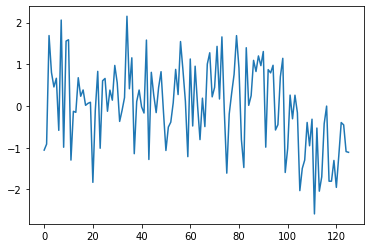

In [44]:
plt.plot(np.arange(126), counts_df["mean"])

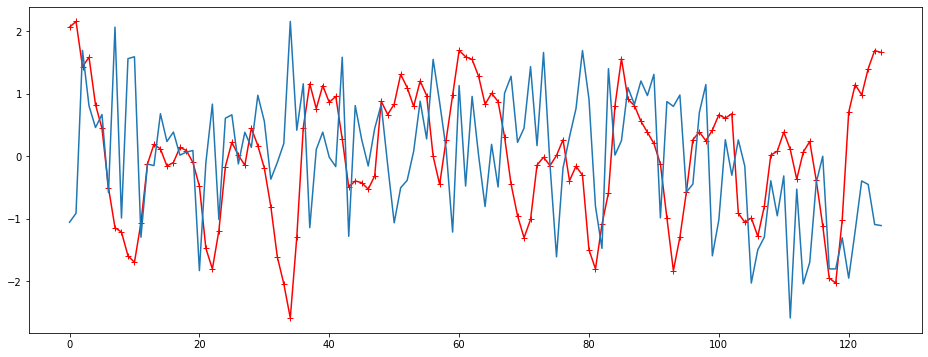

In [50]:
plt.figure(figsize=(16, 6))
plt.plot(np.arange(126), y_train, c="r", marker="+")
# plt.ylabel('y')
# plt.xlabel('x')
plt.plot(np.arange(126), counts_df["mean"])
plt.fill_between(np.arange(126), counts_df["high"], counts_df["low"], alpha=0.5);

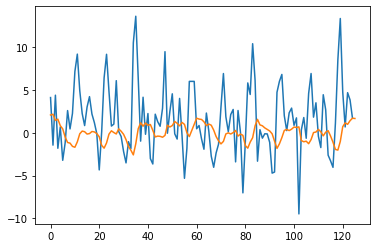

In [57]:
# plt.plot(height)
plt.plot(np.diff(uplift))
plt.plot(y_train)